# O que é o Apache Spark ?

<div style="text-align: justify">O Apache Spark é um framework de computação unificada e um conjunto de bibliotecas para processamento de dados paralelos em clusters de computadores. Spark é o mecanismo de código aberto mais desenvolvido para essa tarefa, tornando-se uma ferramenta padrão para qualquer desenvolvedor ou cientista de dados interessado em big data. O Spark oferece suporte a várias linguagens de programação amplamente utilizadas (Python, Java, Scala e R), inclui bibliotecas para diversas tarefas, desde SQL a fluxo contínuo e aprendizado de máquina, e é executado em qualquer lugar, desde um laptop até um cluster de milhares de servidores. Isso torna o sistema fácil de iniciar e ampliar para processamento de dados grandes ou incrivelmente grande escala.</div> 

## Exemplo Introdutório

<div style="text-align: justify">Usaremos o Spark para analisar alguns dados estatísticos de voo do Bureau de Transporte dos Estados Unidos. Dentro da pasta CSV, você verá que temos vários arquivos. Há também várias outras pastas com diferentes formatos de arquivo. Por enquanto, vamos nos concentrar nos arquivos CSV. Cada arquivo tem um número de linhas dentro dele. Esses arquivos são arquivos CSV, o que significa que eles são um formato de dados semi-estruturados, com cada linha no arquivo representando uma linha em nosso futuro DataFrame.<br><br>
O Spark inclui a capacidade de ler e gravar de um grande número de fontes de dados. Para ler esses dados, usaremos um DataFrameReader associado ao nosso SparkSession. Ao fazer isso, especificaremos o formato do arquivo e as opções que desejamos especificar. No nosso caso, queremos fazer algo chamado inferência de esquema (inferSchema), o que significa que queremos que o Spark adivinhe melhor qual deve ser o esquema de nosso DataFrame. Também queremos especificar que a primeira linha é o cabeçalho do arquivo(header), então vamos especificar isso também como opção. Para obter as informações do esquema, o Spark lê um pouco dos dados e, em seguida, tenta analisar os tipos nessas linhas de acordo com os tipos disponíveis no Spark.</div>

In [1]:
# Definindo o caminho de origem dos arquivos e as opções de leitura
path = "file:///root/sparkcurso/Spark_Definitive_Guide/data/flight-data/csv/2015-summary.csv"
flightData2015 = spark.read.option("inferSchema", "true")\
    .option("header", "true")\
    .csv(path)

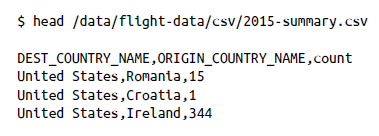
<center>Conteúdo do arquivo .csv exibido através da linha de comando</center>

<div style="text-align: justify">Cada um desses DataFrames (no Scala e no Python) tem um conjunto de colunas com um número não especificado de linhas. A razão pela qual o número de linhas não é especificado é porque a leitura de dados é uma transformação e, portanto, é uma operação lenta. Spark espiou apenas algumas linhas de dados para tentar adivinhar os tipos que cada coluna deveria ter. A figura abaixo fornece uma ilustração do arquivo CSV sendo lido em um DataFrame e, em seguida, sendo convertido em uma matriz local ou lista de linhas.</div>

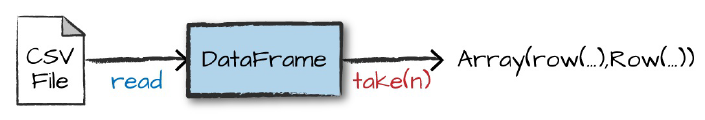

Se executarmos a ação no DataFrame, poderemos ver os mesmos resultados que vimos antes quando usamos a linha de comando:

In [2]:
flightData2015.take(3)

[Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Romania', count=15),
 Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Croatia', count=1),
 Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Ireland', count=344)]

Vamos especificar mais algumas transformações. Vamos classificar os dados de acordo com a coluna "count", que é um tipo inteiro. 

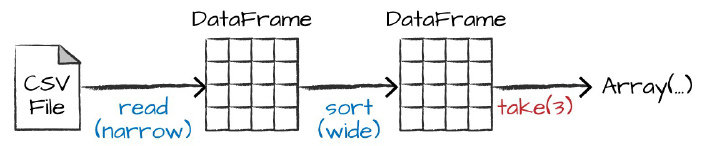

Nada acontece com os dados quando chamamos o comando __sort( )__ porque é apenas uma transformação. No entanto, podemos ver que o Spark está construindo um plano para como ele será executado em todo o cluster, observando o plano de __explain( )__. Podemos chamar o comando ___explain___ em qualquer objeto DataFrame para ver a linhagem do DataFrame (ou como o Spark executará essa consulta):

In [3]:
flightData2015.sort("count").explain()

== Physical Plan ==
*(2) Sort [count#12 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(count#12 ASC NULLS FIRST, 200)
   +- *(1) FileScan csv [DEST_COUNTRY_NAME#10,ORIGIN_COUNTRY_NAME#11,count#12] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/root/sparkcurso/Spark_Definitive_Guide/data/flight-data/csv/2015-summary...., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>


<div style="text-align: justify"> <b>Explain</b> parece bruxaria, mas com um pouco de prática se torna bem compreensível. Você pode ler os planos de explicação de cima para baixo, o topo sendo o resultado final e a parte inferior sendo a fonte de dados. Nesse caso, observe as primeiras palavras-chave. Você verá o <i>sort</i>, <i>exchange</i> e o <i>FileScan</i>. Isso ocorre porque a classificação(sort) de dados é, na verdade, uma transformação abrangente(<i>wide transformation</i>), pois as linhas precisam ser comparadas entre si. Não se preocupe muito em entender tudo sobre os planos de explicação neste momento, eles podem ser apenas ferramentas úteis para depuração e aprimoramento de seus conhecimentos à medida que você avança com o Spark.
Agora, como fizemos antes, podemos especificar uma ação para lançar este plano. No entanto, antes de fazer isso, vamos definir uma configuração. Por padrão, quando executamos um shuffle, o Spark produz 200 partições aleatórias. Vamos definir esse valor como 5 para reduzir o número de partições de saída do shuffle:</div>

In [4]:
# Configurando o número de partições de saída do comando shuffle
spark.conf.set("spark.sql.shuffle.partitions", "5")

In [5]:
flightData2015.sort("count").take(2)

[Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Singapore', count=1),
 Row(DEST_COUNTRY_NAME=u'Moldova', ORIGIN_COUNTRY_NAME=u'United States', count=1)]

A figura abaixo ilustra esta operação. Observe que, além das transformações lógicas, incluímos também a contagem de partições físicas.

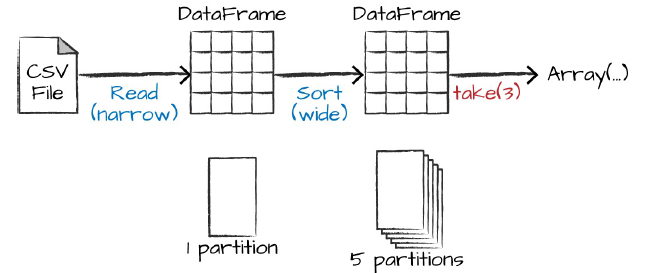

<div style="text-align: justify">O plano lógico de transformações que criamos define uma linhagem para o DataFrame para que, a qualquer momento, o Spark saiba como recalcular qualquer partição executando todas as operações que tinha antes nos mesmos dados de entrada. Isso está no core do modelo de programação do Spark - programação funcional em que as mesmas entradas sempre resultam nas mesmas saídas quando as transformações nesses dados permanecem constantes.
<br><br>
Não manipulamos os dados físicos; em vez disso, configuramos características de execução física por meio de coisas como o parâmetro de partições aleatórias que definimos há alguns instantes. Acabamos com cinco partições de saída, porque esse é o valor que especificamos na partição shuffle. Você pode alterar isso para ajudar a controlar as características de execução física de seus trabalhos do Spark. Ao experimentar valores diferentes, você deverá ver durações drasticamente diferentes. Lembre-se de que você pode monitorar o progresso do trabalho navegando até a interface do usuário do Spark na porta 4040 para ver as características de execução física e lógica de seus trabalhos.</div>

## DataFrames & SQL
<br>
<div style="text-align: justify"> Trabalhamos com uma transformação simples no exemplo anterior, agora vamos trabalhar em um processo mais complexo e acompanhar em DataFrames e SQL. O Spark pode executar as mesmas transformações, independentemente da linguagem, exatamente da mesma maneira. Você pode expressar sua lógica de negócios em SQL ou DataFrames (em R, Python, Scala ou Java) e o Spark compilará essa lógica em um plano subjacente (que você pode ver no plano de explicação) antes de executar seu código. Com o Spark SQL, você pode registrar qualquer DataFrame como uma tabela ou exibição (uma tabela temporária) e consultá-la usando SQL puro. Não há diferença de desempenho entre escrever consultas SQL ou escrever código DataFrame, ambos “compilar” para o mesmo plano subjacente que especificamos no código DataFrame.<div>

In [6]:
# Criando uma tabela temporária para executar queries de maneira simplificada atraves da função .sql
flightData2015.createOrReplaceTempView("flight_data_2015")

<div style="text-align: justify">Agora podemos consultar nossos dados no SQL. Para fazer isso, usaremos a função spark.sql que convenientemente retorna um novo DataFrame. Embora isso possa parecer um pouco circular na lógica - que uma consulta SQL em relação a um DataFrame retorna outro DataFrame - na verdade, é bem poderosa. Isso possibilita que você especifique transformações da maneira mais conveniente para você em um determinado ponto no tempo e não sacrifique qualquer eficiência para fazê-lo.</div>

In [12]:
# Executando uma querie em formato SQL 
sqlWay = spark.sql("SELECT DEST_COUNTRY_NAME, count(1) FROM flight_data_2015 GROUP BY DEST_COUNTRY_NAME").show(2)

+-----------------+--------+
|DEST_COUNTRY_NAME|count(1)|
+-----------------+--------+
|          Moldova|       1|
|          Bolivia|       1|
+-----------------+--------+
only showing top 2 rows



In [11]:
# Executando a mesma querie utilizando funções Spark SQL
dataFrameWay = flightData2015.groupBy("DEST_COUNTRY_NAME").count().show(2)

+-----------------+-----+
|DEST_COUNTRY_NAME|count|
+-----------------+-----+
|          Moldova|    1|
|          Bolivia|    1|
+-----------------+-----+
only showing top 2 rows



Observe que esses planos compilam exatamente o mesmo plano subjacente.

In [14]:
# Query executada através de comandos SQL usando a função .sql 
sqlWay.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#10], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#10, 5)
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#10], functions=[partial_count(1)])
      +- *(1) FileScan csv [DEST_COUNTRY_NAME#10] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/root/sparkcurso/Spark_Definitive_Guide/data/flight-data/csv/2015-summary...., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>


In [15]:
# Query executada através de funções nativas do Spark
dataFrameWay.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#10], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#10, 5)
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#10], functions=[partial_count(1)])
      +- *(1) FileScan csv [DEST_COUNTRY_NAME#10] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/root/sparkcurso/Spark_Definitive_Guide/data/flight-data/csv/2015-summary...., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>


<div style="text-align: justify">Vamos retirar algumas estatísticas interessantes dos nossos dados. Uma coisa a entender é que os DataFrames (e SQL) no Spark já possuem um grande número de manipulações disponíveis. Existem centenas de funções que você pode usar e importar para ajudá-lo a resolver seus problemas de big data mais rapidamente. Usaremos a função <b>max()</b> para estabelecer o número máximo de voos de, e para qualquer localidade. Isso apenas verifica cada valor na coluna relevante no DataFrame e verifica se ele é maior que os valores anteriores que foram vistos. Isso é uma transformação, porque estamos efetivamente filtrando para uma linha.</div>

In [16]:
from pyspark.sql.functions import max
flightData2015.select(max("count")).take(1)

[Row(max(count)=370002)]

<div style="text-align: justify">Vamos realizar algo um pouco mais complicado e encontrar os cinco principais países de destino nos dados. Esta é a nossa primeira consulta de multitransformação, por isso vamos dar um passo a passo. Vamos começar com uma agregação SQL bastante simples:</div>

In [17]:
maxSql = spark.sql("SELECT DEST_COUNTRY_NAME, sum(count)\
    as destination_total FROM flight_data_2015\
    GROUP BY DEST_COUNTRY_NAME\
    ORDER BY sum(count) DESC\
    LIMIT 5")
maxSql.show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



<div style="text-align: justify">Agora, vamos para a sintaxe do DataFrame que é semanticamente semelhante, mas ligeiramente diferente na implementação e na ordenação. Mas, como mencionamos, os planos subjacentes para ambos são os mesmos. Vamos executar as consultas e ver os resultados delas como comparação:</div>

In [18]:
from pyspark.sql.functions import desc
flightData2015.groupBy("DEST_COUNTRY_NAME")\
    .sum("count")\
    .withColumnRenamed("sum(count)", "destination_total")\
    .sort(desc("destination_total"))\
    .limit(5)\
    .show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



<div style="text-align: justify">Agora, há sete etapas que nos levam de volta aos dados de origem. Você pode ver isso no plano de explicação nesses DataFrames. A Figura abaixo mostra o conjunto de etapas que executamos no “código”. O plano de execução verdadeiro (aquele visível em explain) será diferente daquele mostrado no esquema que segue devido a otimizações na execução física; no entanto, a ilustração vale como ponto de partida. Esse plano de execução é um gráfico acíclico direcionado (DAG) de transformações, cada uma resultando em um novo DataFrame imutável, no qual chamamos uma ação para gerar um resultado.</div>

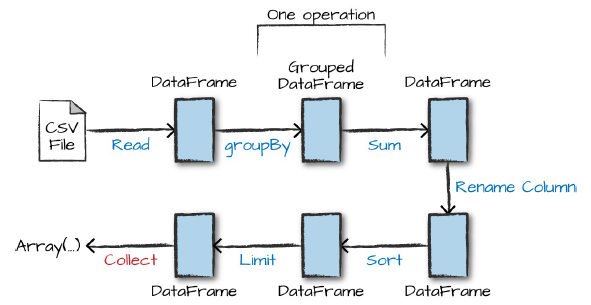<br>
<center>Fluxo de transformação do DataFrame

<div style="text-align: justify">1. Ler os dados. Definimos o DataFrame anteriormente, mas, como um lembrete, o Spark não o lê até que uma ação seja chamada nesse DataFrame ou um derivado do DataFrame original.<br><br>
2. Nosso agrupamento; tecnicamente, quando chamamos <i>groupBy</i>, acabamos com um <i>RelationalGroupedDataset</i>, que é um nome sofisticado para um DataFrame que tem um agrupamento especificado, mas precisa que o usuário especifique uma agregação antes de poder ser consultado mais detalhadamente. Basicamente, especificamos que vamos agrupar por uma chave (ou conjunto de chaves) e que agora vamos realizar uma agregação sobre cada uma dessas chaves.    
<br><br>3. Especificar a agregação. Vamos usar o método de agregação de soma. Isso leva como entrada uma expressão de coluna ou, simplesmente, um nome de coluna. O resultado da chamada do método sum é um novo DataFrame. Você verá que tem um novo esquema, mas conhece o tipo de cada coluna. É importante reforçar que nenhum cálculo foi realizado. Essa é simplesmente outra transformação que expressamos, e o Spark é simplesmente capaz de rastrear nossas informações de tipo por meio dela. 
<br><br>4. Renomeação simples. Usamos o método withColumnRenamed que recebe dois argumentos, o nome da coluna original e o novo nome da coluna. Claro, isso não faz computação: esta é apenas outra transformação! 
<br><br>5. Classificar os dados de modo que, se fôssemos tirar os resultados da parte superior do DataFrame, eles teriam os maiores valores na coluna <i>destination_total</i>. 
<br><br>Você provavelmente notou que precisávamos importar uma função para fazer isso, a função desc. Você também deve ter notado que desc não retorna uma string, mas uma coluna. Em geral, muitos métodos DataFrame aceitarão strings (como nomes de coluna) ou tipos ou expressões de Coluna. Colunas e expressões são exatamente a mesma coisa.    
<br><br>6. Especificar um limite. Isso apenas especifica que só queremos retornar os primeiros cinco valores em nosso DataFrame final em vez de todos os dados. 
<br><br>7. A nossa ação! Agora, realmente iniciamos o processo de coleta dos resultados de nosso DataFrame, e o Spark nos devolverá uma lista ou matriz na linguagem que estamos executando. Para reforçar tudo isso, vamos ver o plano de explicação da query anterior:</div>

In [19]:
flightData2015.groupBy("DEST_COUNTRY_NAME")\
    .sum("count")\
    .withColumnRenamed("sum(count)", "destination_total")\
    .sort(desc("destination_total"))\
    .limit(5)\
    .explain()

== Physical Plan ==
TakeOrderedAndProject(limit=5, orderBy=[destination_total#112L DESC NULLS LAST], output=[DEST_COUNTRY_NAME#10,destination_total#112L])
+- *(2) HashAggregate(keys=[DEST_COUNTRY_NAME#10], functions=[sum(cast(count#12 as bigint))])
   +- Exchange hashpartitioning(DEST_COUNTRY_NAME#10, 5)
      +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#10], functions=[partial_sum(cast(count#12 as bigint))])
         +- *(1) FileScan csv [DEST_COUNTRY_NAME#10,count#12] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/root/sparkcurso/Spark_Definitive_Guide/data/flight-data/csv/2015-summary...., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,count:int>


<div style="text-align: justify">Embora este plano de explicação não corresponda ao nosso <i>plano conceitual</i> exato, todas as peças estão lá. Você pode ver a declaração de limite, bem como o <i>orderBy</i> (na primeira linha). Você também pode ver como nossa agregação acontece em duas fases, nas chamadas <i>partial_sum</i>. Isso ocorre porque a soma de uma lista de números é comutativa e o Spark pode executar a soma, partição por partição. É claro que podemos ver como lemos no DataFrame também. Naturalmente, nem sempre precisamos coletar os dados. Também podemos escrevê-lo para qualquer fonte de dados que o Spark ofereça suporte. Por exemplo, suponha que queremos armazenar as informações em um banco de dados como o PostgreSQL ou escrevê-las em outro arquivo.</div>

Material baseado em exemplos do livro __Spark - The Definitive Guide. Bill Chambers e Matei Zaharia__